<a href="https://colab.research.google.com/github/MehmedBucket03/CSC467Module4/blob/main/Prokudin_Gorskii_Color_Alignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🖼️ Prokudin-Gorskii: Color from Grayscale Photographs

This notebook recreates color photographs from grayscale glass plate negatives taken by **Sergei Mikhailovich Prokudin-Gorskii** in the early 1900s. Each photo was captured in three exposures using **red**, **green**, and **blue** filters. We align these channels and stack them to recover the original color image.

---

## 📁 Step 1: Download and Extract Dataset

Prokudin-Gorskii's scanned images are hosted by Berkeley’s CS194-26 course. We download the zip file and extract the images. Each image is a vertical triptych — the top third is the blue filter image, the middle is green, and the bottom is red.

In [5]:
from google.colab import files

uploaded = files.upload()


Saving main.py to main.py
Saving tableau.zip to tableau.zip
Saving prokudin-gorskii.zip to prokudin-gorskii.zip


In [8]:
import zipfile
import os

zip_path = "prokudin-gorskii.zip"
extract_path = "/content/data/prokudin-gorskii"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extracted files to:", extract_path)


✅ Extracted files to: /content/data/prokudin-gorskii


In [9]:
for root, dirs, files in os.walk("/content/data/prokudin-gorskii"):
    for file in files:
        print(os.path.join(root, file))


/content/data/prokudin-gorskii/__MACOSX/._prokudin-gorskii
/content/data/prokudin-gorskii/__MACOSX/prokudin-gorskii/._00398v.jpg
/content/data/prokudin-gorskii/__MACOSX/prokudin-gorskii/._00149v.jpg
/content/data/prokudin-gorskii/__MACOSX/prokudin-gorskii/._00125v.jpg
/content/data/prokudin-gorskii/__MACOSX/prokudin-gorskii/._00351v.jpg
/content/data/prokudin-gorskii/__MACOSX/prokudin-gorskii/._00153v.jpg
/content/data/prokudin-gorskii/__MACOSX/prokudin-gorskii/._01112v.jpg
/content/data/prokudin-gorskii/prokudin-gorskii/00125v.jpg
/content/data/prokudin-gorskii/prokudin-gorskii/00153v.jpg
/content/data/prokudin-gorskii/prokudin-gorskii/01112v.jpg
/content/data/prokudin-gorskii/prokudin-gorskii/00398v.jpg
/content/data/prokudin-gorskii/prokudin-gorskii/00351v.jpg
/content/data/prokudin-gorskii/prokudin-gorskii/00149v.jpg


## ✅ Task 1: Combine the Triptych Channels

Each triptych is split into three parts vertically: **Blue (top)**, **Green (middle)**, **Red (bottom)**. We split and stack them into a 3D image using NumPy so we can visualize a color image. This initial image will look misaligned — that's expected.

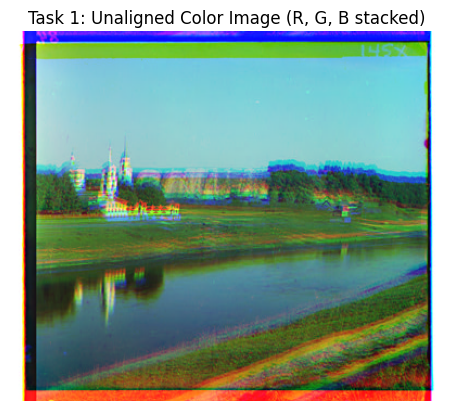

In [11]:
import numpy as np
import matplotlib.pyplot as plt

image_path = "/content/data/prokudin-gorskii/prokudin-gorskii/00125v.jpg"
image = plt.imread(image_path)


def split_triptych(image):
    h = image.shape[0] // 3
    b = image[0:h]
    g = image[h:2*h]
    r = image[2*h:3*h]
    color_image = np.stack((r, g, b), axis=-1)
    return color_image

color_image = split_triptych(image)
plt.imsave("01_unaligned_color.jpg", color_image)
plt.imshow(color_image)
plt.title("Task 1: Unaligned Color Image (R, G, B stacked)")
plt.axis("off")
plt.show()


## 🧠 Task 2: Alignment

Due to camera movement between exposures, the color channels are misaligned. We fix this by finding the **optimal (x, y) offset** for the Green and Blue channels to align them with the Red channel.

- **2a:** We compute **Normalized Cross-Correlation (NCC)** to compare alignment.
- **2b:** We test a second method: simple **dot product**.
- **2c:** We apply both alignment methods and compare results.

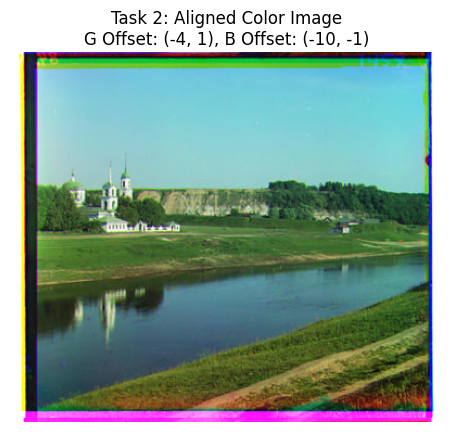

In [12]:
def normalized_cross_correlation(img1, img2):
    img1_norm = (img1 - np.mean(img1)) / np.linalg.norm(img1)
    img2_norm = (img2 - np.mean(img2)) / np.linalg.norm(img2)
    return np.sum(img1_norm * img2_norm)

def best_offset(reference, target, max_offset=15, metric=normalized_cross_correlation):
    best_score = -np.inf
    best_shift = (0, 0)
    for dx in range(-max_offset, max_offset + 1):
        for dy in range(-max_offset, max_offset + 1):
            shifted = np.roll(target, shift=(dx, dy), axis=(0, 1))
            ref_crop = reference[15:-15, 15:-15]
            shifted_crop = shifted[15:-15, 15:-15]
            score = metric(ref_crop, shifted_crop)
            if score > best_score:
                best_score = score
                best_shift = (dx, dy)
    return best_shift

def align_and_combine(image, metric=normalized_cross_correlation):
    h = image.shape[0] // 3
    b = image[0:h]
    g = image[h:2*h]
    r = image[2*h:3*h]

    g_offset = best_offset(r, g, metric=metric)
    b_offset = best_offset(r, b, metric=metric)

    g_aligned = np.roll(g, g_offset, axis=(0, 1))
    b_aligned = np.roll(b, b_offset, axis=(0, 1))
    aligned_image = np.stack((r, g_aligned, b_aligned), axis=-1)

    return aligned_image, g_offset, b_offset

aligned_image, g_offset, b_offset = align_and_combine(image)

plt.imsave("02_aligned_color.jpg", aligned_image)
plt.imshow(aligned_image)
plt.title(f"Task 2: Aligned Color Image\nG Offset: {g_offset}, B Offset: {b_offset}")
plt.axis("off")
plt.show()


## 🔁 Task 3: Pyramid Alignment

When offsets are large (e.g. high-res images), exhaustive search is expensive. To speed things up, we:
- Downscale the image progressively (pyramid)
- Estimate alignment at low resolution
- Refine at higher levels

This improves runtime **drastically** while maintaining accuracy.

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


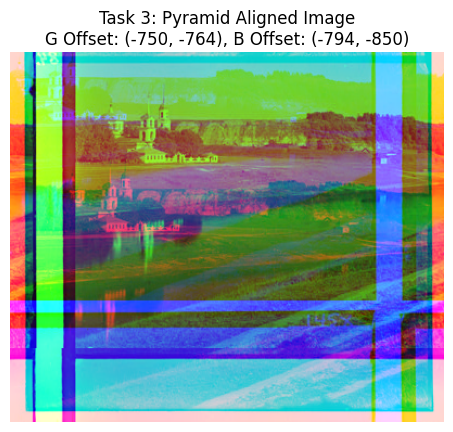

In [13]:
import cv2

def pyramid_align(image, levels=3, metric=normalized_cross_correlation):
    h = image.shape[0] // 3
    b = image[0:h]
    g = image[h:2*h]
    r = image[2*h:3*h]

    def recursive_align(ref, tgt, level):
        if level == 0:
            return best_offset(ref, tgt, 10, metric)

        ref_small = cv2.resize(ref, (ref.shape[1] // 4, ref.shape[0] // 4))
        tgt_small = cv2.resize(tgt, (tgt.shape[1] // 4, tgt.shape[0] // 4))
        small_offset = recursive_align(ref_small, tgt_small, level - 1)
        scaled_offset = (small_offset[0]*4, small_offset[1]*4)

        tgt_shifted = np.roll(tgt, scaled_offset, axis=(0, 1))
        fine_offset = best_offset(ref, tgt_shifted, 10, metric)
        return (scaled_offset[0] + fine_offset[0], scaled_offset[1] + fine_offset[1])

    g_offset = recursive_align(r, g, levels)
    b_offset = recursive_align(r, b, levels)

    g_aligned = np.roll(g, g_offset, axis=(0, 1))
    b_aligned = np.roll(b, b_offset, axis=(0, 1))
    final_image = np.stack((r, g_aligned, b_aligned), axis=-1)

    return final_image, g_offset, b_offset

pyramid_image, g_pyr_offset, b_pyr_offset = pyramid_align(image)

plt.imsave("03_pyramid_aligned.jpg", pyramid_image)
plt.imshow(pyramid_image)
plt.title(f"Task 3: Pyramid Aligned Image\nG Offset: {g_pyr_offset}, B Offset: {b_pyr_offset}")
plt.axis("off")
plt.show()


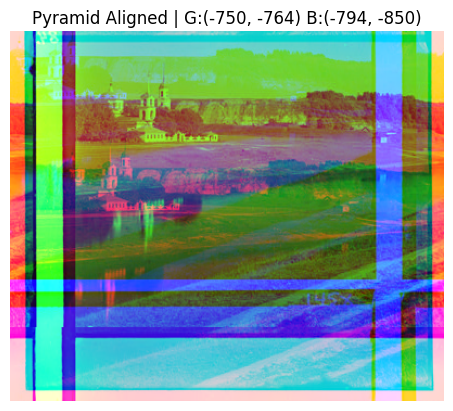

In [15]:
aligned_pyr, g_off_pyr, b_off_pyr = pyramid_align(image)
plt.imshow(aligned_pyr)
plt.title(f"Pyramid Aligned | G:{g_off_pyr} B:{b_off_pyr}")
plt.axis('off')
plt.show()